In [1]:
import numpy as np
import pandas as pd
from customized import preprocess
from customized import metrics
from customized import repeat_coverage
from striatum import MAB
from striatum.storage.action import Action
from neural_exploration import neuralucb_main
# import importlib
# importlib.reload(metrics)

product feature: (10, 768)
streamer feature: (10, 23)
small streamer-product: (10, 791)


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Recommend Ratio: 96.00 %
Accuracy: 48.00 %
Correct: 48
Regret: 0.52


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
 27% (27 of 100) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00

Recommend Ratio: 100.00 %
Accuracy: 50.00 %
Correct: 50
Regret: 0.5
Recommend Ratio: 99.00 %
Accuracy: 51.00 %
Correct: 51
Regret: 0.49


100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Recommend Ratio: 97.00 %
Accuracy: 51.00 %
Correct: 51
Regret: 0.49
aenn's regret: 0.52
vaenn's regret: 0.5
aebnn's regret: 0.49
vaebnn's regret: 0.49


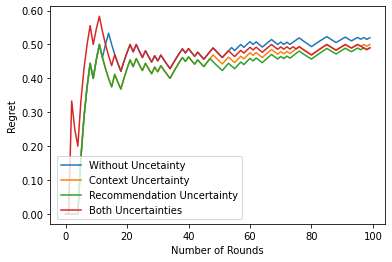

aenn's coverage: 0.86
vaenn's coverage: 1.0
aebnn's coverage: 0.98
vaebnn's coverage: 1.0


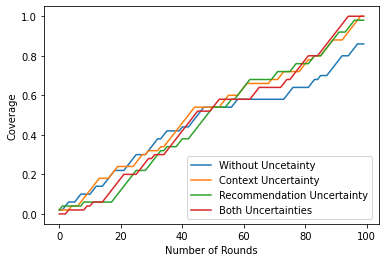

aenn's hit ratio: 12.0 %
vaenn's hit ratio: 12.0 %
aebnn's hit ratio: 12.0 %
vaebnn's hit ratio: 12.0 %


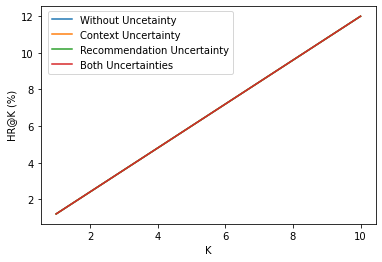

In [2]:
experiments = ['aenn', 'vaenn', 'aebnn', 'vaebnn']
mylabels = ['Without Uncetainty', 'Context Uncertainty', 'Recommendation Uncertainty', 'Both Uncertainties']
fig_name = 'lers_uncertainty'
regrets_structure, hr_structure, coverage_structure, repeat_reward_pivot, cust_id, reward_cust_id, reward_prod_id, topk_structure = \
                                                repeat_coverage.main(experiments, mylabels, fig_name, 100, 10)

# MAB

In [3]:
# import importlib
# importlib.reload(MAB)
def countif_name(df, axis=0, condition=1.0): 
    dic = {}
    if axis == 0: # row # movie
        for i in range(df.shape[1]): 
            dic[df.columns[i]] = (df.iloc[:,i] == condition).sum() # 這部電影有多少人喜歡
        result = pd.DataFrame.from_dict(dic, orient='index').rename(columns={0:'cnt'})
    elif axis == 1: # column # user
        for i in range(df.shape[0]): 
            dic[df.index[i]] = (df.iloc[i,:] == condition).sum() # 這個人喜歡多少部電影
        result = pd.DataFrame.from_dict(dic, orient='index').rename(columns={0:'cnt'})
    return result

def main(num, full_context, context_id, rewards, streamer_proudct, lers_regret, lers_hr, lers_coverage): # 2602人, 815dim
    
    actions = []
    for prod_id in streamer_proudct:
        action = Action(int(prod_id))
        actions.append(action)
    user_features = pd.DataFrame(np.array(full_context), index=context_id)
    repeat_rewards_df = pd.melt(rewards, ignore_index=False, var_name='商品id', value_name='reward')\
                    .loc[context_id[:10]].reset_index()
    print(f"user features: {user_features.shape}, reward targets: {rewards.shape}")
    
    experiment_bandit = ['aenn','vaenn','aebnn','vaebnn', 'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB', 'random']
    mab_bandit = ['random', 'UCB1', 'LinUCB', 'Exp3']
    mylabels = ['LERS (Without Uncertainty)','LERS (Context Uncertainty)','LERS (Recommendation Uncertainty)', 'LERS (Both Uncertainties)', \
               'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB', 'Random']
    predict_id = {}
    rec_id = {}
    regret = {}
    hr = {}
    topk = {}
    coverage_dict = {} 
    miss_rate_dict = {}
    i = 0 # for coverage

    for bandit in experiment_bandit:   
        if bandit in mab_bandit:      
            print("-----")
            print(bandit)
            policy = MAB.policy_generation(bandit, actions)
            seq_error, rec_id[bandit], predict_id[bandit] = MAB.policy_evaluation(policy, bandit, num, user_features, rewards, actions, len(actions))
            regret[bandit] = MAB.regret_calculation(seq_error)
            if bandit != 'random':
                hr[bandit], k_list, topk[bandit] = metrics.cal_hit_ratio_mab(repeat_rewards_df, predict_id[bandit], min_val=1, max_val=11, step=1)

            # coverage
            coverage_list = []
            miss_rate_list = []
            rec_table = pd.DataFrame({'algo': bandit, 'user': rewards.iloc[:,0], 'rec_id': rec_id[bandit]})  # 我只要知道重複來的user是誰
            list1 = list(rewards.index)
            list2 = rec_table['rec_id']
            user_list = list1[0:10]
            algo_dict = {}
            for u, m in zip(list1, list2):
                algo_dict.setdefault(u, []).append(m)
            correct_movie = pd.DataFrame([])
            wrong_movie = pd.DataFrame([])
            r = 0
            count_user_likes = countif_name(rewards, axis = 1, condition = 1.0)
            count_user_hates = countif_name(rewards, axis = 1, condition = 0.0) 
            for k,v in algo_dict.items():
                user_likes_cnt = count_user_likes.loc[k][0] # 每個user喜歡的電影數 # 5部
                user_hate_cnt = count_user_hates.loc[k][0]
                if user_likes_cnt == 0:
                    print(f"[Round {r}] User {k} has no favor movie.")
                else:
                    for m in v:  # v is a list
                        r += 1   # r means the recommend times of movies
                        preference = (rewards.loc[[k], [str(m)]]).values[0] # 因為k(user)在外層loop所以會重複10次, 只要取第一個值即可
                        if preference == 1.0:     # 確實喜歡
                            correct_movie = correct_movie.append(pd.DataFrame({'user': k, 'correct_movie': m}, index=[i]), ignore_index=True)  # algo推薦的movie同時也是user確實喜歡(猜對)的movie清單
                        elif preference == 0.0:
                            wrong_movie = wrong_movie.append(pd.DataFrame({'user': k, 'wrong_movie': m}, index=[i]), ignore_index=True) 

                        uni_correct_set = correct_movie.drop_duplicates() 
                        uni_wrong_set = wrong_movie.drop_duplicates() 

                        if uni_correct_set.shape[0] != 0:  
                            # 總體
                            correct_cnt_table = pd.DataFrame({'cnt':uni_correct_set.groupby(["user"]).size()})['cnt'] 
                            overall_cum_cnt = sum(correct_cnt_table.values)
                            overall_cover_ratio = overall_cum_cnt/(user_likes_cnt*len(set(list1))) # 所有user喜歡的電影總數 # 50部 
                            coverage_list.append(overall_cover_ratio)

                            if (r==num):
                                print("=====hit=====")
                                print(f"[Final] cumulative cover ratio is: {overall_cum_cnt/50: .4f}")
                                print(correct_cnt_table)

                        else:                   # 推薦的並不喜歡
                            coverage_list.append(0)

                        if wrong_movie.shape[0] != 0:  
                            wrong_cnt_table = pd.DataFrame({'cnt':uni_wrong_set.groupby(["user"]).size()})['cnt'] 
                            overall_cum_cnt = sum(wrong_cnt_table.values)
                            overall_miss_ratio = overall_cum_cnt/(user_hate_cnt*len(set(list1))) # 所有user喜歡的電影總數 # 50部 
                            miss_rate_list.append(overall_miss_ratio)

                            if (r==num):
                                print("=====miss=====")
                                print(f"[Final] cumulative miss ratio is: {overall_cum_cnt/50: .4f}")
                                print(wrong_cnt_table)
                        else:
                            miss_rate_list.append(0)
            coverage_dict[bandit] = coverage_list
            miss_rate_dict[bandit] = miss_rate_list

#             print(len(coverage_list), len(miss_rate_list))
            
        elif bandit == 'NeuralUCB':
            neuralUCB_regret, neuralUCB_reward_df, predict_id[bandit] = neuralucb_main.myNeuralUCB(user_features, rewards, p=0.2, hidden_size=32, epochs=10, use_cuda=False, seed=np.random.seed(2022))
            regret['NeuralUCB'] = neuralUCB_regret
            hr[bandit], _, topk[bandit] = metrics.cal_hit_ratio_neuralucb(repeat_rewards_df, predict_id[bandit], min_val=1, max_val=11, step=1)
            neuralUCB_cover_miss = neuralucb_main.coverage(neuralUCB_reward_df)
            coverage_dict['NeuralUCB'] = neuralUCB_cover_miss['cover']
            miss_rate_dict['NeuralUCB'] = neuralUCB_cover_miss['miss']
        else:
            regret[bandit] = lers_regret[bandit]
            hr[bandit] = lers_hr[bandit]
            coverage_dict[bandit] = lers_coverage[bandit]
        i += 1
        
        
    # plot regret 
    metrics.plot_regret(regret, mylabels, 'all_uncertainty', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    # plot hit ratio
    metrics.plot_hit_ratio(hr, k_list, mylabels, 'all_uncertainty', bbox_to_anchor=(1.02, 1), loc=2)    
    # plot coverage     
    metrics.plot_coverage(coverage_dict, mylabels, 'all_uncertainty', bbox_to_anchor=(1.02, 1), loc=2)
    
    return regret, rec_id, topk

## blurry_context

user features: (100, 20), reward targets: (100, 10)
-----
UCB1
Correct 51
=====hit=====
[Final] cumulative cover ratio is:  0.6600
user
10216769084013373    2
1182060652291740     3
132951068172795      2
147570737452163      4
1595107157361238     3
2246906995347384     4
3240887732596929     4
4976976049064048     4
5821434374564784     4
6185796358112538     3
Name: cnt, dtype: int64
=====miss=====
[Final] cumulative miss ratio is:  0.6400
user
10216769084013373    5
1182060652291740     3
132951068172795      3
147570737452163      2
1595107157361238     4
2246906995347384     3
3240887732596929     2
4976976049064048     3
5821434374564784     3
6185796358112538     4
Name: cnt, dtype: int64
-----
LinUCB
Correct 77
=====hit=====
[Final] cumulative cover ratio is:  0.2800
user
10216769084013373    1
1182060652291740     2
132951068172795      1
147570737452163      1
1595107157361238     2
2246906995347384     1
3240887732596929     1
4976976049064048     2
5821434374564784     2
6

  0% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

=====hit=====
[Final] cumulative cover ratio is:  0.5200
user
10216769084013373    1
1182060652291740     3
132951068172795      3
147570737452163      3
1595107157361238     2
2246906995347384     4
3240887732596929     3
4976976049064048     2
5821434374564784     3
6185796358112538     2
Name: cnt, dtype: int64
=====miss=====
[Final] cumulative miss ratio is:  0.7200
user
10216769084013373    4
1182060652291740     3
132951068172795      1
147570737452163      3
1595107157361238     4
2246906995347384     4
3240887732596929     4
4976976049064048     5
5821434374564784     4
6185796358112538     4
Name: cnt, dtype: int64


100% (100 of 100) |######################| Elapsed Time: 0:00:09 Time:  0:00:09


-----
random
Correct 47
=====hit=====
[Final] cumulative cover ratio is:  0.6000
user
10216769084013373    3
1182060652291740     3
132951068172795      2
147570737452163      2
1595107157361238     3
2246906995347384     2
3240887732596929     4
4976976049064048     3
5821434374564784     4
6185796358112538     4
Name: cnt, dtype: int64
=====miss=====
[Final] cumulative miss ratio is:  0.6400
user
10216769084013373    5
1182060652291740     4
132951068172795      3
147570737452163      4
1595107157361238     2
2246906995347384     2
3240887732596929     2
4976976049064048     4
5821434374564784     3
6185796358112538     3
Name: cnt, dtype: int64
aenn's regret: 0.52
vaenn's regret: 0.5
aebnn's regret: 0.49
vaebnn's regret: 0.49
UCB1's regret: [0.48]
LinUCB's regret: [0.22]
Exp3's regret: [0.53]
NeuralUCB's regret: 0.49
random's regret: [0.52]


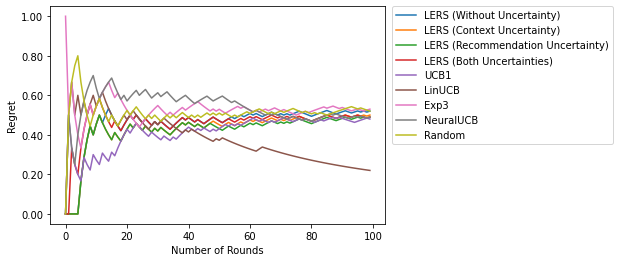

aenn's hit ratio: 12.0 %
vaenn's hit ratio: 12.0 %
aebnn's hit ratio: 12.0 %
vaebnn's hit ratio: 12.0 %
UCB1's hit ratio: 12.0 %
LinUCB's hit ratio: 12.0 %
Exp3's hit ratio: 12.0 %
NeuralUCB's hit ratio: 2.0 %


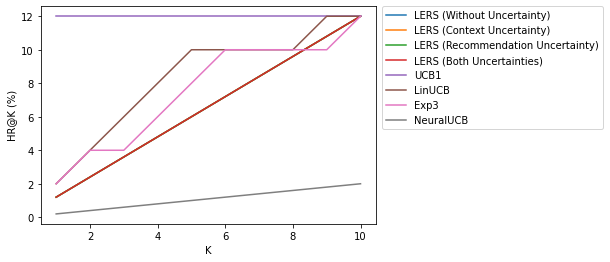

aenn's coverage: 0.86
vaenn's coverage: 1.0
aebnn's coverage: 0.98
vaebnn's coverage: 1.0
UCB1's coverage: 0.825
LinUCB's coverage: 0.35
Exp3's coverage: 0.65
NeuralUCB's coverage: 0.72
random's coverage: 0.75


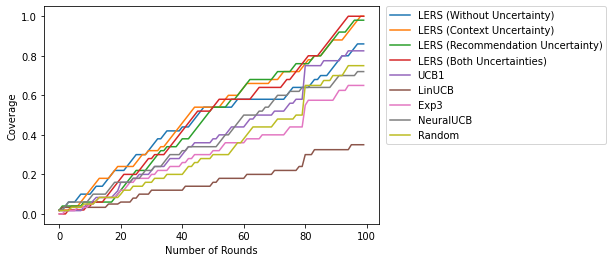

In [4]:
mab_context = np.load('data/mab_latent.npy')
mab_context, mab_context_id, _ = preprocess.trim_cust_for_context_sort(mab_context, cust_id, reward_cust_id)
regret, rec_id, topk_mab = main(len(mab_context_id), mab_context, mab_context_id, \
                                  repeat_reward_pivot, reward_prod_id, \
                                  regrets_structure, hr_structure, coverage_structure) 


In [10]:
topk_mab['UCB1'] # 最後一人的topk=10

['5117160',
 '5117255',
 '5123078',
 '5118335',
 '5118877',
 '5117658',
 '5121283',
 '5121557',
 '5117316',
 '5129047']

In [11]:
topk_structure[-1] # vaebnn # 10人的最後一次(k=10)的推薦

[98, 91, 99, 90, 96, 94, 95, 93, 92, 97]